In [7]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, DenseNet121_Weights, EfficientNet_B0_Weights, EfficientNet_B3_Weights
import cv2
import numpy as np

In [10]:
class ResNet18(nn.Module):
    """
    ResNet-18 model for multi-label classification.
    Source: "Deep Residual Learning for Image Recognition" by He et al., 2015.
    https://arxiv.org/abs/1512.03385
    """
    def __init__(self, num_classes, pretrained=True):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT if pretrained else None)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [15]:
import torch
import torch.nn.functional as F

# Code extracted from MIT licensed code Copyright (c) 2021 Alinstein Jose
# Implementation of "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
# From the paper "arXiv:1610.02391"
class Grad_CAM(object):
    """Calculate GradCAM salinecy map.

    A simple example:

        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcam = GradCAM(model_dict)

        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)

        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)

        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)


    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        self.model_arch = model_dict['arch']

        self.gradients = dict()
        self.activations = dict()
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None
        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        # Modification to the code to make it work with my models
        target_layer = self.model_arch.layer4

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        if verbose:
            try:
                input_size = model_dict['input_size']
            except KeyError:
                print("please specify size of input image in model_dict. e.g. {'input_size':(224, 224)}")
                pass
            else:
                device = 'cuda' if next(self.model_arch.parameters()).is_cuda else 'cpu'
                self.model_arch(torch.zeros(1, 3, *(input_size), device=device))
                print('saliency_map size :', self.activations['value'].shape[2:])


    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()
        torch.set_grad_enabled(True)
        logit = self.model_arch(input)

        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        # score = Variable(score, requires_grad=True)
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        #alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)
    
def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
        
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """

    # Squeeze the mask to make it 2D (H, W)
    mask = mask.squeeze().cpu().detach().numpy()  # Convert to numpy and remove extra dimensions

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])

    result = heatmap + img
    result = result.div(result.max()).squeeze()
    result = result - result.min()
    result = result / result.max()
    return heatmap, result

In [19]:
# Initialize GradCAM for ResNet18
model = ResNet18(num_classes=14, pretrained=True)  # Example: 5 output classes
model.load_state_dict(torch.load('./saves/res18_asl1_Adam/best_model.pth'))  # Load the best weights
model.eval()

# Define model details for GradCAM
model_dict = dict(
    type='resnet',  # Specify the type of model ('resnet' or 'densenet')
    arch=model.model,  # Pass the internal model
    layer_name='layer4',  # Specify the layer to hook for CAM
    input_size=(256, 256)  # Input image size (optional but recommended)
)


C:\Users\hugoa\AppData\Local\Temp\ipykernel_4044\2316549303.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./saves/res18_asl1_Adam/bes

In [20]:
print(model)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [21]:
gradcam = Grad_CAM(model_dict)

C:\Users\hugoa\AppData\Local\Temp\ipykernel_4044\1637718971.py:93: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)


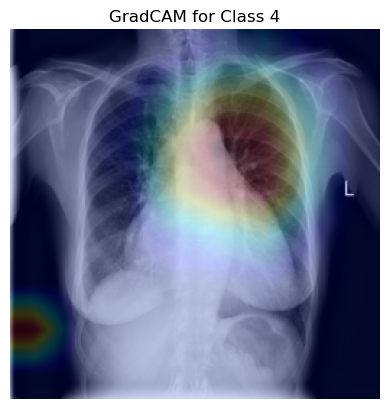

In [33]:
from PIL import Image
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

image = Image.open('./resized_images/00000211_004.png').convert("RGB")

input_image = transform(image)

input_image = input_image.unsqueeze(0)

# Class index for which to generate CAM
class_idx = 4

mask, logit = gradcam(input_image, class_idx=class_idx)

heatmap, result = visualize_cam(mask, input_image)

# Displaying the result using matplotlib (code unchanged)
import matplotlib.pyplot as plt

plt.imshow(result.permute(1, 2, 0).detach().numpy()) 
plt.title(f'GradCAM for Class {class_idx}')
plt.axis('off')
plt.show()